In [9]:
# Laod occupations, compute co-occurenxce

import sqlite3
import pandas as pd
import plotly.express as px
import sys
import plotly.graph_objects as go

sys.path.append('../')
from functions_env import DB_PATH


conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()


In [12]:
df_ind = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)


df_ind_year = df_ind[["individual_wikidata_id", "birthyear", "individual_name"]].drop_duplicates()
df_ind_year = df_ind_year[~df_ind_year['birthyear'].isna()]
df_ind_year["productive_year"] = df_ind_year["birthyear"] + 35
temporal_resolution = 10
df_ind_year["decade"] = df_ind_year["productive_year"].apply(lambda x: round(x / temporal_resolution) * temporal_resolution)
df_ind_year = df_ind_year[df_ind_year['decade']<=1850]

,individual_wikidata_id,birthyear,individual_name,productive_year,decade
0,Q55844134,1810.0,Ernst von Heeringen,1845.0,1840
1,Q202809,1803.0,Frederick Coombs,1838.0,1840
3,Q33934701,1768.0,Margarethe Sömmering,1803.0,1800
4,Q4350107,1785.0,Vassili Perevoštšikov,1820.0,1820
5,Q1028749,1683.0,Christian Friedrich Zincke,1718.0,1720
...,...,...,...,...,...
220497,Q2977815,1752.0,Claude Michallon,1787.0,1790
220498,Q12331758,1706.0,Peter Wichmann,1741.0,1740
220499,Q6408679,696.0,Kim Gyo-gak,731.0,730
220500,Q312788,1686.0,Nicola Porpora,1721.0,1720


In [75]:
df_occupation = pd.read_sql_query("SELECT * FROM individual_occupations", conn)
top_occupations = df_occupation.occupations_name.value_counts().head(100)
top_occupations = list(top_occupations.index)

df_occupation = df_occupation[df_occupation['occupations_name'].isin(top_occupations)]
df_occupation

df_final = pd.merge(df_ind_year, df_occupation, on = 'individual_wikidata_id')
df_final = df_final[['individual_wikidata_id', 'birthyear', 'occupations_name']].drop_duplicates()

df_before = df_final[df_final['birthyear']<=1500]

import random


list_individuals = list(df_before.individual_wikidata_id)
sample_ind = random.sample(list_individuals, 1000)
df_before = df_before[df_before['individual_wikidata_id'].isin(sample_ind)]
df_before = df_before.reset_index(drop=True)

df_after = df_final[df_final['birthyear']>1500]
list_individuals = list(df_after.individual_wikidata_id)
sample_ind = random.sample(list_individuals, 1000)
df_after = df_after[df_after['individual_wikidata_id'].isin(sample_ind)]
df_after = df_after.reset_index(drop=True)

In [76]:
import typing as t
def coocurrence_multiple(data_network:pd.DataFrame(),index_var :str, variables:t.List[str]) -> pd.DataFrame:

        fin_list = []
        for var in variables:
            df_var = data_network[[index_var, var]]
            df_var = df_var.drop_duplicates()
            df_var = (
                df_var.groupby([index_var, var])[index_var]
                .count()
                .rename("weight")
                .reset_index()
            )
            df_var = df_var.rename(columns={var: "data"})
            df_var["entity"] = var
            fin_list.append(df_var)
        
        fin = pd.concat([x for x in fin_list])
        df_co = pd.merge(fin, fin, on=index_var)
        df_co["product"] = df_co["weight_x"] * df_co["weight_y"]
        edges = df_co.groupby(["data_x", "data_y"])["product"].sum().reset_index()
        edges.columns = ["source", "target", "weight"]

        return edges

In [77]:

from node2vec import Node2Vec

import networkx as nx

def compute_mean(df_before):

    df_edge = coocurrence_multiple(df_before, index_var='individual_wikidata_id', variables = ['occupations_name'])
    G = nx.from_pandas_edgelist(
                df_edge, source="source", target="target", edge_attr="weight"
            )

    node2vec = Node2Vec(G, dimensions=700, workers=5)
    model = node2vec.fit(window=30, min_count=1)

    nodes = list(map(str, G.nodes()))
    embeddings = np.array([model.wv[x] for x in nodes])
    df_embeddings = pd.DataFrame(embeddings)
    df_embeddings.index = nodes

    dist_cos = cosine_similarity(df_embeddings)
    dist_cos = pd.DataFrame(dist_cos, index=df_embeddings.index, columns=df_embeddings.index)
    dist_cos = 1 - dist_cos
    average_mean = dist_cos.mean()
    average_mean = average_mean.reset_index()
    average_mean.columns = ['occupation', 'distance']

    return average_mean


average_mean_before = compute_mean(df_before)
average_mean_before['type'] = 'before_1500'

average_mean_after = compute_mean(df_after)
average_mean_after['type'] = 'after_1500'

Computing transition probabilities:   0%|          | 0/74 [00:00<?, ?it/s]

Generating walks (CPU: 5): 100%|██████████| 2/2 [00:00<00:00, 77.04it/s]


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Generating walks (CPU: 5): 100%|██████████| 2/2 [00:00<00:00, 50.39it/s]


In [61]:
average_mean_before['distance'].mean()

0.63904613

In [62]:
average_mean_after['distance'].mean()

0.5755061

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_28656/4171646763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='distance', data=df_fig, palette='Set2')


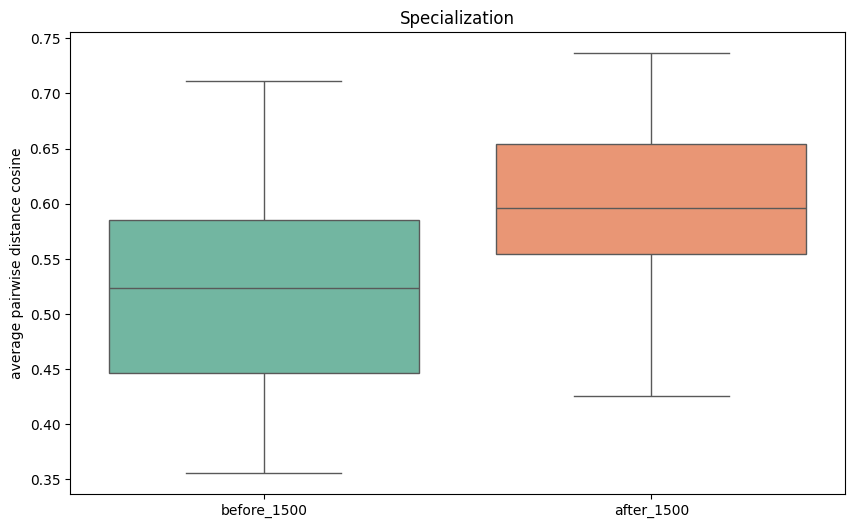

In [80]:
df_fig = pd.concat([average_mean_before,average_mean_after])
df_fig = df_fig.drop('occupation', axis=1)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='distance', data=df_fig, palette='Set2')
plt.title('Specialization')
plt.xlabel('')
plt.ylabel('average pairwise distance cosine')
plt.savefig('figures/wikidata_stats/specialization.png', dpi = 200)

plt.show()